In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import scipy.spatial
import functools
from scipy.spatial.distance import cdist

%matplotlib inline

## 6.2-1 kernel method computation

In [10]:
### Kernel function generators
def linear_kernel(X1, X2):
    """
    Computes the linear kernel between two sets of vectors.
    Args:
        X1 - an n1xd matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2xd matrix with vectors x2_1,...,x2_n2 in the rows
    Returns:
        matrix of size n1xn2, with x1_i^T x2_j in position i,j
    """
    return np.dot(X1,np.transpose(X2))
 
def RBF_kernel(X1,X2,sigma):
    """
    Computes the RBF kernel between two sets of vectors   
    Args:
        X1 - an n1xd matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2xd matrix with vectors x2_1,...,x2_n2 in the rows
        sigma - the bandwidth (i.e. standard deviation) for the RBF/Gaussian kernel
    Returns:
        matrix of size n1xn2, with exp(-||x1_i-x2_j||^2/(2 sigma^2)) in position i,j
    """
    return np.exp(-cdist(X1,X2,'sqeuclidean')/(2*sigma**2))

def polynomial_kernel(X1, X2, offset, degree):
    """
    Computes the inhomogeneous polynomial kernel between two sets of vectors
    Args:
        X1 - an n1xd matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2xd matrix with vectors x2_1,...,x2_n2 in the rows
        offset, degree - two parameters for the kernel
    Returns:
        matrix of size n1xn2, with (offset + <x1_i,x2_j>)^degree in position i,j
    """
    return (offset+linear_kernel(X1,X2))**degree


## 6.2-2 compute kernel matrix

In [19]:
x_0 = np.array([[-4],[-1],[0],[2]])
linear_kernel(x_0,x_0)

array([[16,  4,  0, -8],
       [ 4,  1,  0, -2],
       [ 0,  0,  0,  0],
       [-8, -2,  0,  4]])

## 6.2-3-a

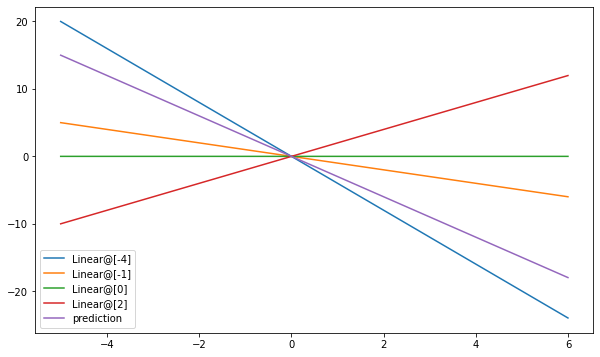

In [30]:
plot_step = .01
xpts = np.arange(-5.0, 6, plot_step).reshape(-1,1)
'''
a = [1,2,3,4,5]
a.reshape(-1,1) => [[1],[2],[3],[4],[5]] 
'''
prototypes = np.array([-4,-1,0,2]).reshape(-1,1) ## kernel machine에서는 트레이닝 데이터를 prototype이라고도 한다.

# Linear kernel
y = linear_kernel(prototypes, xpts) 
plt.figure(figsize=(10,6))
prediction = np.zeros(y.shape[1])
for i in range(len(prototypes)):
    label = "Linear@"+str(prototypes[i,:])
    plt.plot(xpts, y[i,:], label=label)
    prediction += y[i,:]
plt.plot(xpts, prediction, label='prediction')
plt.legend(loc = 'best')
plt.show() 
 
 

## 6.2-3-b

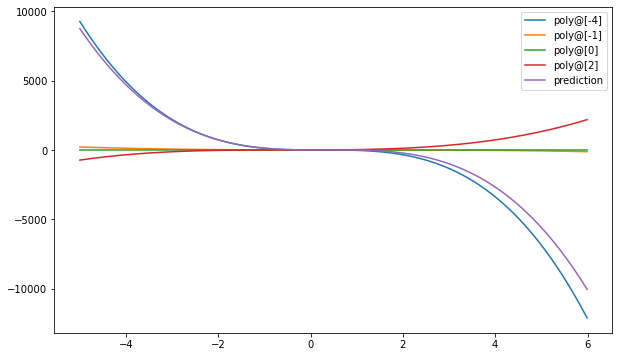

In [31]:
plot_step = .01
xpts = np.arange(-5.0, 6, plot_step).reshape(-1,1)
prototypes = np.array([-4,-1,0,2]).reshape(-1,1)
plt.figure(figsize=(10,6))

y = polynomial_kernel(prototypes, xpts, 1, 3)
prediction = np.zeros(y.shape[1])
for i in range(len(prototypes)):
    label = "poly@"+str(prototypes[i,:])
    plt.plot(xpts, y[i,:], label=label)
    prediction += y[i,:]
plt.plot(xpts, prediction, label='prediction')
plt.legend(loc = 'best')
plt.show() 

## 6.2-3-c
 - 각 prototype값에서 값이 제일 높게 나온다. 즉, rbf커널은 각 prototype값과의 유사도라고 생각할 수 있음.

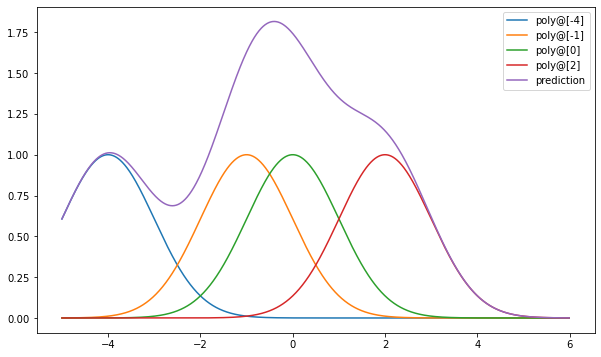

In [33]:
plot_step = .01
xpts = np.arange(-5.0, 6, plot_step).reshape(-1,1)
prototypes = np.array([-4,-1,0,2]).reshape(-1,1)
plt.figure(figsize=(10,6))


y = RBF_kernel(prototypes, xpts, 1)
prediction = np.zeros(y.shape[1])
for i in range(len(prototypes)):
    label = "poly@"+str(prototypes[i,:])
    plt.plot(xpts, y[i,:], label=label)
    prediction += y[i,:]    
plt.plot(xpts, prediction, label='prediction')
plt.legend(loc = 'best')
plt.show() 

## 6.2-3-d

In [34]:
class Kernel_Machine(object):
    def __init__(self, kernel, prototype_points, weights):
        """
        Args:
            kernel(X1,X2) - a function return the cross-kernel matrix between rows of X1 and rows of X2 for kernel k
            prototype_points - an Rxd matrix with rows mu_1,...,mu_R
            weights - a vector of length R with entries w_1,...,w_R
        """

        self.kernel = kernel
        self.prototype_points = prototype_points
        self.weights = weights
        
    def predict(self, X):
        """
        Evaluates the kernel machine on the points given by the rows of X
        Args:
            X - an nxd matrix with inputs x_1,...,x_n in the rows
        Returns:
            Vector of kernel machine evaluations on the n points in X.  Specifically, jth entry of return vector is
                Sum_{i=1}^R w_i k(x_j, mu_i)
        """
        return np.dot(self.kernel(X,self.prototype_points),self.weights)

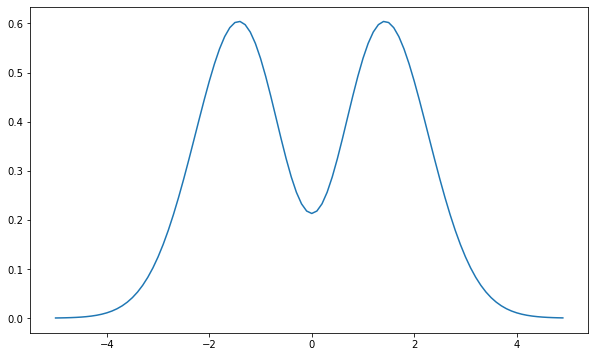

In [37]:
prototypes = np.array([-1,0,1]).reshape(-1,1)
weights = np.array([1,-1,1])
x = np.arange(-5,5,0.1).reshape(-1,1)

kernel = functools.partial(RBF_kernel, sigma=1)
kernel_machine = Kernel_Machine(kernel, prototypes, weights)
prediction = kernel_machine.predict(x)

plt.figure(figsize=(10,6))
plt.plot(x,prediction)

Load train & test data; Convert to column vectors so it generalizes well to data in higher dimensions.

In [38]:
data_train,data_test = np.loadtxt("krr-train.txt"),np.loadtxt("krr-test.txt") ## numpy로 txt파일도 load할 수 있다.
x_train, y_train = data_train[:,0].reshape(-1,1),data_train[:,1].reshape(-1,1)
x_test, y_test = data_test[:,0].reshape(-1,1),data_test[:,1].reshape(-1,1)

## 6.3-1

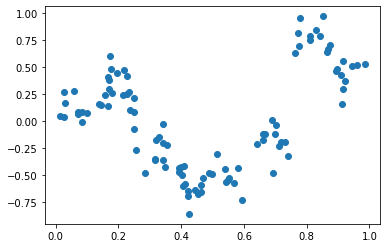

In [40]:
plt.scatter(x_train,y_train)

## 6.3-2

In [48]:
def train_kernel_ridge_regression(X, y, kernel, l2reg):
    kernel_mat = kernel(X,X)
    try:
        inverse = np.linalg.inv(l2reg*np.identity(X.shape[0]) + kernel_mat)
    except np.linalg.LinAlgError:
        print('(lambda*I + kernel matrix) is not invertible')
        return
    alpha = np.dot(inverse,y)
    return Kernel_Machine(kernel, X, alpha)

## 6.3-3
 - sigma가 작을수록 오버피팅이 일어난다.
 - sigma가 작다는 것은 RBF의 feature vector의 각 요소값이 크다는 것이기 때문.

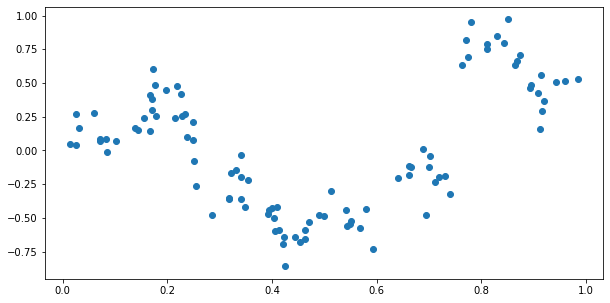

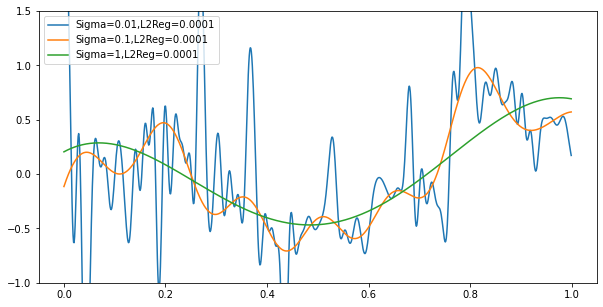

In [58]:
plot_step = .001
xpts = np.arange(0 , 1, plot_step).reshape(-1,1)
plt.figure(figsize=(10,5))
plt.plot(x_train,y_train,'o')
l2reg = 0.0001
plt.figure(figsize=(10,5))
for sigma in [.01,.1,1]:
    k = functools.partial(RBF_kernel, sigma=sigma)
    f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
    label = "Sigma="+str(sigma)+",L2Reg="+str(l2reg)
    plt.plot(xpts, f.predict(xpts), label=label)
plt.legend(loc = 'best')
plt.ylim(-1,1.5)
plt.show()

## 6.3-4

 - lambda가 작을수록 오버피팅
 - 원래 svm의 식은 다음과 같다 : $\frac{1}{2}\|w\|^2 + \frac{c}{m}\sum_{i=1}^{m}max(0, 1-y_iw^Tx_i)$
 - 즉 이 경우 c값을 조절함으로써 regularization을 해준다. c가 작을수록 regularization이 된다.
 - 다만 여기서는 $\frac{\lambda}{2}\|w\|^2 + \frac{1}{m}\sum_{i=1}^{m}max(0, 1-y_iw^Tx_i)$ 로 구현했기 때문에 lambda가 클수록 regularization이 더 된다.

 - lambda를 100으로 하면 거의 직선인데 이는 RBF의 featur vector의 고차항들은 거의 0이 되었다는 것이다.
 - RBF의 feature vector의 feature들은 고차항일수록 계수가 작다(즉 scale이 작다는 뜻).
 - regularization을 적용하면 scale이 작은 feature에는 가중치를 거의 주지 못하게 한다.
 - 그래서 lambda가 커지면서 거의 flat한 형태가 되는 것.

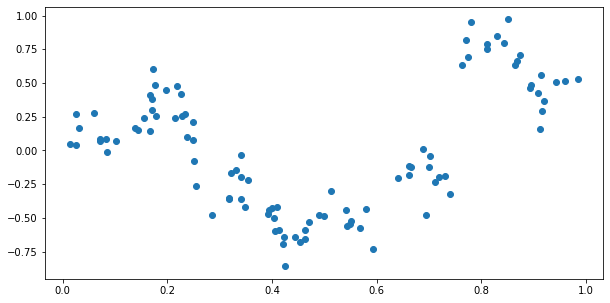

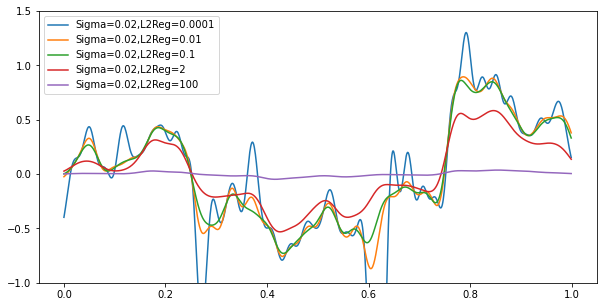

In [59]:
plot_step = .001
xpts = np.arange(0 , 1, plot_step).reshape(-1,1)
plt.figure(figsize=(10,5))
plt.plot(x_train,y_train,'o')
sigma= .02
plt.figure(figsize=(10,5))
for l2reg in [.0001,.01,.1,2,100]:
    k = functools.partial(RBF_kernel, sigma=sigma)
    f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
    label = "Sigma="+str(sigma)+",L2Reg="+str(l2reg)
    plt.plot(xpts, f.predict(xpts), label=label)
plt.legend(loc = 'best')
plt.ylim(-1,1.5)
plt.show()

## 6.3-5

In [60]:
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin

class KernelRidgeRegression(BaseEstimator, RegressorMixin):  
    """sklearn wrapper for our kernel ridge regression.
       이걸 써야 GridSearchCV를 쓸 수 있음.
    """
     
    def __init__(self, kernel="RBF", sigma=1, degree=2, offset=1, l2reg=1):        
        self.kernel = kernel
        self.sigma = sigma
        self.degree = degree
        self.offset = offset
        self.l2reg = l2reg 

    def fit(self, X, y=None):
        """
        This should fit classifier. All the "work" should be done here.
        """
        if (self.kernel == "linear"):
            self.k = linear_kernel
        elif (self.kernel == "RBF"):
            self.k = functools.partial(RBF_kernel, sigma=self.sigma)
        elif (self.kernel == "polynomial"):
            self.k = functools.partial(polynomial_kernel, offset=self.offset, degree=self.degree)
        else:
            raise ValueError('Unrecognized kernel type requested.')
        
        self.kernel_machine_ = train_kernel_ridge_regression(X, y, self.k, self.l2reg)

        return self

    def predict(self, X, y=None):
        try:
            getattr(self, "kernel_machine_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")

        return(self.kernel_machine_.predict(X))

    def score(self, X, y=None):
        # get the average square error
        return(((self.predict(X)-y)**2).mean()) 

In [61]:
from sklearn.model_selection import GridSearchCV,PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error,make_scorer
import pandas as pd
    
test_fold = [-1]*len(x_train) + [0]*len(x_test)   #0 corresponds to test, -1 to train
predefined_split = PredefinedSplit(test_fold=test_fold)

In [67]:
param_grid = [{'kernel': ['RBF'],'sigma':[.1,1,10], 'l2reg': np.exp2(-np.arange(-5,5,1))},
              {'kernel':['polynomial'],'offset':[-1,0,1], 'degree':[2,3,4],'l2reg':[10, .1, .01] },
              {'kernel':['linear'],'l2reg': [10,1,.01]}]
kernel_ridge_regression_estimator = KernelRidgeRegression()
grid = GridSearchCV(kernel_ridge_regression_estimator, 
                    param_grid,
                    cv = predefined_split,
                    scoring = make_scorer(mean_squared_error,greater_is_better = False),
                    return_train_score=True,
                    n_jobs = -1  #allow parallelism
                   )
grid.fit(np.vstack((x_train,x_test)),np.vstack((y_train,y_test))) 

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=KernelRidgeRegression(), n_jobs=-1,
             param_grid=[{'kernel': ['RBF'],
                          'l2reg': array([32.    , 16.    ,  8.    ,  4.    ,  2.    ,  1.    ,  0.5   ,
        0.25  ,  0.125 ,  0.0625]),
                          'sigma': [0.1, 1, 10]},
                         {'degree': [2, 3, 4], 'kernel': ['polynomial'],
                          'l2reg': [10, 0.1, 0.01], 'offset': [-1, 0, 1]},
                         {'kernel': ['linear'], 'l2reg': [10, 1, 0.01]}],
             return_train_score=True,
             scoring=make_scorer(mean_squared_error, greater_is_better=False))

In [68]:
pd.set_option('display.max_rows', 20)
df = pd.DataFrame(grid.cv_results_)
# Flip sign of score back, because GridSearchCV likes to maximize,
# so it flips the sign of the score if "greater_is_better=FALSE"
df['mean_test_score'] = -df['mean_test_score']
df['mean_train_score'] = -df['mean_train_score']
cols_to_keep = ["param_degree", "param_kernel","param_l2reg" ,"param_offset","param_sigma",
        "mean_test_score","mean_train_score"]
df_toshow = df[cols_to_keep].fillna('-')
df_toshow.sort_values(by=["mean_test_score"])

,param_degree,param_kernel,param_l2reg,param_offset,param_sigma,mean_test_score,mean_train_score
27,-,RBF,0.0625,-,0.1,0.021270,0.023245
24,-,RBF,0.1250,-,0.1,0.022885,0.024608
21,-,RBF,0.2500,-,0.1,0.024845,0.026226
18,-,RBF,0.5000,-,0.1,0.026609,0.028110
15,-,RBF,1.0000,-,0.1,0.027562,0.030319
...,...,...,...,...,...,...,...
5,-,RBF,16.0000,-,10,0.167949,0.210743
2,-,RBF,32.0000,-,10,0.167995,0.210809
51,4,polynomial,0.1000,-1,-,0.188090,0.148359
30,2,polynomial,10.0000,-1,-,0.202746,0.239150


In [ ]:
# Can be a more convenient way to look at the table
import qgrid 
#qgrid.nbinstall(overwrite=True)  # copies javascript dependencies to your /nbextensions folderd_toshow = df[show].fillna('-')
qgrid.show_grid(df_toshow)

 - RBF 결과

In [76]:
# df_toshow[df_toshow['param_kernel'] == 'RBF'].head()
df_toshow[df_toshow.param_kernel == 'RBF'].sort_values(by=['mean_test_score']).head()

,param_degree,param_kernel,param_l2reg,param_offset,param_sigma,mean_test_score,mean_train_score
27,-,RBF,0.0625,-,0.1,0.021270,0.023245
24,-,RBF,0.1250,-,0.1,0.022885,0.024608
21,-,RBF,0.2500,-,0.1,0.024845,0.026226
18,-,RBF,0.5000,-,0.1,0.026609,0.028110
15,-,RBF,1.0000,-,0.1,0.027562,0.030319


 - polynomial 결과

In [77]:
df_toshow[df_toshow.param_kernel == 'polynomial'].sort_values(by=['mean_test_score']).head()

,param_degree,param_kernel,param_l2reg,param_offset,param_sigma,mean_test_score,mean_train_score
54,4,polynomial,0.01,-1,-,0.043454,0.060135
56,4,polynomial,0.01,1,-,0.060262,0.088844
33,2,polynomial,0.10,-1,-,0.065554,0.098913
38,2,polynomial,0.01,1,-,0.066532,0.097785
36,2,polynomial,0.01,-1,-,0.066915,0.097706


 - linear 결과

In [78]:
df_toshow[df_toshow.param_kernel == 'linear'].sort_values(by=['mean_test_score']).head()

,param_degree,param_kernel,param_l2reg,param_offset,param_sigma,mean_test_score,mean_train_score
58,-,linear,1.00,-,-,0.164540,0.206506
59,-,linear,0.01,-,-,0.164569,0.206501
57,-,linear,10.00,-,-,0.164591,0.206780


## 6.3-6

 - 주어진 데이터에 대해서는 잘 맞추기는 했음.
 - 근데 0~1을 벗어나는 범위에서는 예측값이 급격하게 변한다.
 - 0~1을 벗어나는 범위에서는 데이터가 없으니 이게 잘못 된건지 확신할 수는 없긴함.

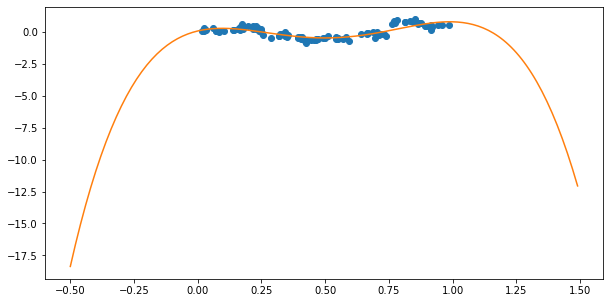

In [79]:
## Plot the best polynomial and RBF fits you found
plot_step = .01
xpts = np.arange(-.5 , 1.5, plot_step).reshape(-1,1)
plt.figure(figsize=(10,5))
plt.plot(x_train,y_train,'o')
#Plot best polynomial fit
offset= -1
degree = 4
l2reg = 0.01
k = functools.partial(polynomial_kernel, offset=offset, degree=degree)
f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
label = "Offset="+str(offset)+",Degree="+str(degree)+",L2Reg="+str(l2reg)
plt.plot(xpts, f.predict(xpts), label=label)


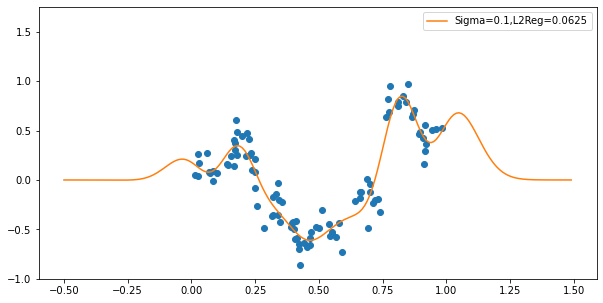

In [80]:
plot_step = .01
xpts = np.arange(-.5 , 1.5, plot_step).reshape(-1,1)
plt.figure(figsize=(10,5))
plt.plot(x_train,y_train,'o')
#Plot best RBF fit
sigma = 0.1
l2reg= 0.0625
k = functools.partial(RBF_kernel, sigma=sigma)
f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
label = "Sigma="+str(sigma)+",L2Reg="+str(l2reg)
plt.plot(xpts, f.predict(xpts), label=label)
plt.legend(loc = 'best')
plt.ylim(-1,1.75)
plt.show()

## 6.3-7
- bayes decision function = f(x)
- bayes risk = $0.1^2$

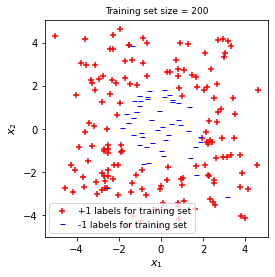

In [81]:
# Load and plot the SVM data
#load the training and test sets
data_train,data_test = np.loadtxt("svm-train.txt"),np.loadtxt("svm-test.txt")
x_train, y_train = data_train[:,0:2], data_train[:,2].reshape(-1,1)
x_test, y_test = data_test[:,0:2], data_test[:,2].reshape(-1,1)

#determine predictions for the training set
yplus = np.ma.masked_where(y_train[:,0]<=0, y_train[:,0])
xplus = x_train[~np.array(yplus.mask)]
yminus = np.ma.masked_where(y_train[:,0]>0, y_train[:,0])
xminus = x_train[~np.array(yminus.mask)]

#plot the predictions for the training set
figsize = plt.figaspect(1)
f, (ax) = plt.subplots(1, 1, figsize=figsize) 

pluses = ax.scatter (xplus[:,0], xplus[:,1], marker='+', c='r', label = '+1 labels for training set')
minuses = ax.scatter (xminus[:,0], xminus[:,1], marker=r'$-$', c='b', label = '-1 labels for training set')

ax.set_ylabel(r"$x_2$", fontsize=11)
ax.set_xlabel(r"$x_1$", fontsize=11)
ax.set_title('Training set size = %s'% len(data_train), fontsize=9)  
ax.axis('tight')
ax.legend(handles=[pluses, minuses], fontsize=9)
plt.show()

In [82]:
# Code to help plot the decision regions
# (Note: This ode isn't necessarily entirely appropriate for the questions asked. So think about what you are doing.)
 
sigma=1
k = functools.partial(RBF_kernel, sigma=sigma)
f = train_soft_svm(x_train, y_train, k, ...)

#determine the decision regions for the predictions
x1_min = min(x_test[:,0])
x1_max= max(x_test[:,0])
x2_min = min(x_test[:,1])
x2_max= max(x_test[:,1])
h=0.1
xx, yy = np.meshgrid(np.arange(x1_min, x1_max, h),
                     np.arange(x2_min, x2_max, h))

Z = f.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

#determine the predictions for the test set
y_bar = f.predict (x_test) 
yplus = np.ma.masked_where(y_bar<=0, y_bar)
xplus = x_test[~np.array(yplus.mask)]
yminus = np.ma.masked_where(y_bar>0, y_bar)
xminus = x_test[~np.array(yminus.mask)]

#plot the learned boundary and the predictions for the test set
figsize = plt.figaspect(1)
f, (ax) = plt.subplots(1, 1, figsize=figsize) 
decision =ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
pluses = ax.scatter (xplus[:,0], xplus[:,1], marker='+', c='b', label = '+1 prediction for test set')
minuses = ax.scatter (xminus[:,0], xminus[:,1], marker=r'$-$', c='b', label = '-1 prediction for test set')
ax.set_ylabel(r"$x_2$", fontsize=11)
ax.set_xlabel(r"$x_1$", fontsize=11)
ax.set_title('SVM with RBF Kernel: training set size = %s'% len(data_train), fontsize=9)  
ax.axis('tight')
ax.legend(handles=[pluses, minuses], fontsize=9)
plt.show()

NameError: name 'train_soft_svm' is not defined